In [8]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

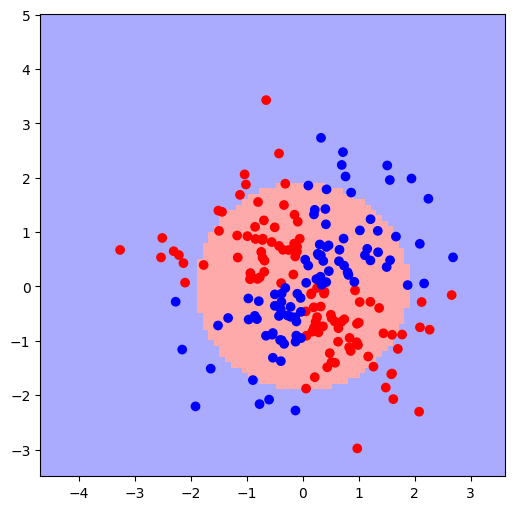

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)

class net3(nn.Module):
    def __init__(self,input_size,nodes,output_size):
        super(net3,self).__init__()
#        self.l1 = nn.Linear(input_size,nodes)
#        self.activation = nn.Tanh()

    def forward(self,x):
#        output = self.l1(x)
#        output = self.activation(output)
        a = torch.mul(x[:,1],x[:,1])
        b = torch.mul(x[:,2],x[:,2])
        c = (a+b)/9.0
        output = torch.exp(c)
        return output

def draw_example(nodes,name,model):
    x_train, y_train, label_train = read_data(name,'train')
    x_test, y_test, label_test = read_data(name,'test')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6*(1+0)))

    h = .1  # step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = np.zeros([xx.shape[0],yy.shape[1]],dtype='float32')
    Z2 = np.zeros([nodes,xx.shape[0],yy.shape[1]],dtype='float32')
    grid_data = np.ones([1,3],dtype='float32')

    grid_data2 = np.zeros([1,3],dtype='float32')
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            x = xx[i,j]
            y = yy[i,j]
            grid_data2[0,0] = 1.0
            grid_data2[0,1] = x
            grid_data2[0,2] = y

            x = torch.from_numpy(grid_data2)
            pred = model(x)
            if (pred[0].item()-6.0) > -4.5:
                yh = 1.0
            else:
                yh = 0.0
            Z[i,j] = yh
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:,0], cmap=cmap_bold)

nodes = 3
name = 'xor'
model = net3(3,nodes,1)
draw_example(nodes,name,model=model)



In [10]:
#  Define the FFNN model
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x  # Raw logits for CrossEntropyLoss



In [18]:
# Define the training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1000):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
            val_loss = val_running_loss / len(val_loader.dataset)
            val_losses.append(val_loss)
        
        # Optionally print progress
        if (epoch+1) % 100 == 0 or epoch == 1:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    return train_losses, val_losses



Processing dataset: xor

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.8378, Validation Loss: 0.7312
Epoch [100/1000], Training Loss: 0.6759, Validation Loss: 0.7152
Epoch [200/1000], Training Loss: 0.6625, Validation Loss: 0.7071
Epoch [300/1000], Training Loss: 0.6440, Validation Loss: 0.6922
Epoch [400/1000], Training Loss: 0.6243, Validation Loss: 0.6734
Epoch [500/1000], Training Loss: 0.5932, Validation Loss: 0.6392
Epoch [600/1000], Training Loss: 0.5513, Validation Loss: 0.5921
Epoch [700/1000], Training Loss: 0.5241, Validation Loss: 0.5592
Epoch [800/1000], Training Loss: 0.5128, Validation Loss: 0.5517
Epoch [900/1000], Training Loss: 0.5083, Validation Loss: 0.5491
Epoch [1000/1000], Training Loss: 0.5068, Validation Loss: 0.5489
Validation Accuracy for k=2: 0.7050

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.6904, Validation Loss: 0.7314
Epoch [100/1000], Training Loss: 0.6667, Validation Loss: 0.7074
Epoch [200/1000], Train

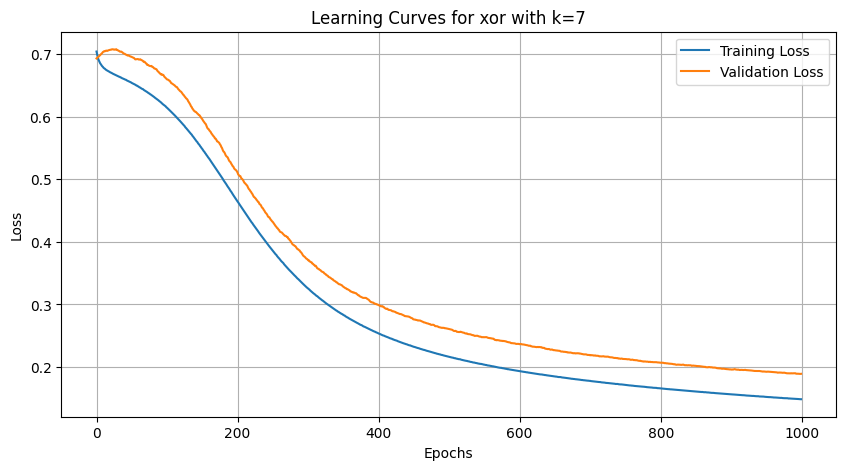

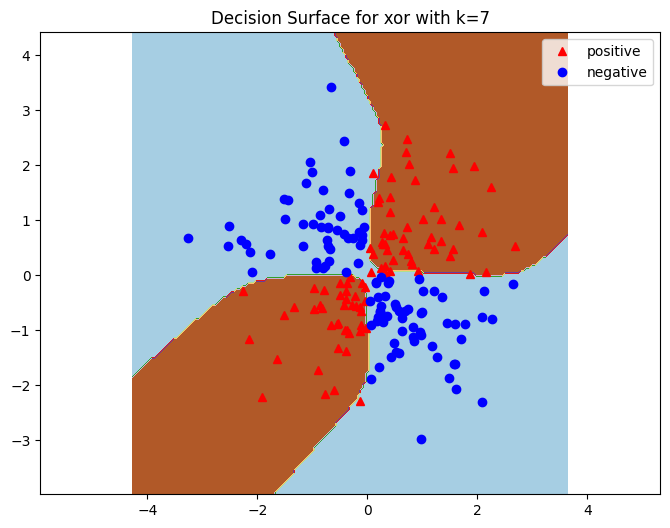


Processing dataset: center_surround

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.7586, Validation Loss: 0.7474
Epoch [100/1000], Training Loss: 0.5702, Validation Loss: 0.5384
Epoch [200/1000], Training Loss: 0.4979, Validation Loss: 0.4594
Epoch [300/1000], Training Loss: 0.4759, Validation Loss: 0.4226
Epoch [400/1000], Training Loss: 0.4652, Validation Loss: 0.3990
Epoch [500/1000], Training Loss: 0.4593, Validation Loss: 0.3893
Epoch [600/1000], Training Loss: 0.4554, Validation Loss: 0.3821
Epoch [700/1000], Training Loss: 0.4524, Validation Loss: 0.3790
Epoch [800/1000], Training Loss: 0.4508, Validation Loss: 0.3772
Epoch [900/1000], Training Loss: 0.4489, Validation Loss: 0.3742
Epoch [1000/1000], Training Loss: 0.4477, Validation Loss: 0.3736
Validation Accuracy for k=2: 0.8650

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.7053, Validation Loss: 0.7032
Epoch [100/1000], Training Loss: 0.5791, Validation Loss: 0.5596
Epoch [200/

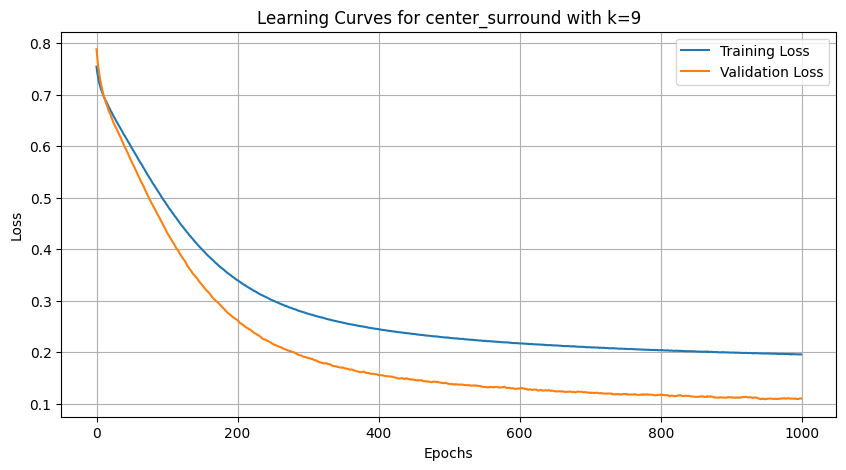

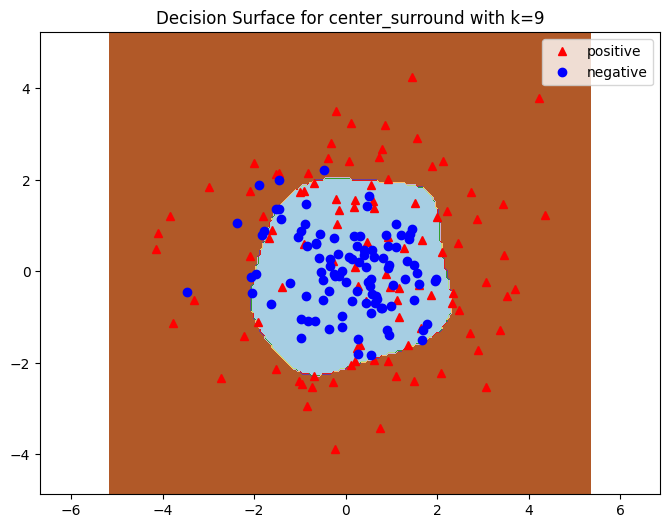


Processing dataset: two_gaussians

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.5914, Validation Loss: 0.5593
Epoch [100/1000], Training Loss: 0.1420, Validation Loss: 0.1058
Epoch [200/1000], Training Loss: 0.1276, Validation Loss: 0.0880
Epoch [300/1000], Training Loss: 0.1249, Validation Loss: 0.0840
Epoch [400/1000], Training Loss: 0.1238, Validation Loss: 0.0831
Epoch [500/1000], Training Loss: 0.1233, Validation Loss: 0.0826
Epoch [600/1000], Training Loss: 0.1232, Validation Loss: 0.0817
Epoch [700/1000], Training Loss: 0.1227, Validation Loss: 0.0818
Epoch [800/1000], Training Loss: 0.1229, Validation Loss: 0.0817
Epoch [900/1000], Training Loss: 0.1228, Validation Loss: 0.0823
Epoch [1000/1000], Training Loss: 0.1228, Validation Loss: 0.0821
Validation Accuracy for k=2: 0.9750

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.7298, Validation Loss: 0.7157
Epoch [100/1000], Training Loss: 0.1554, Validation Loss: 0.1216
Epoch [200/10

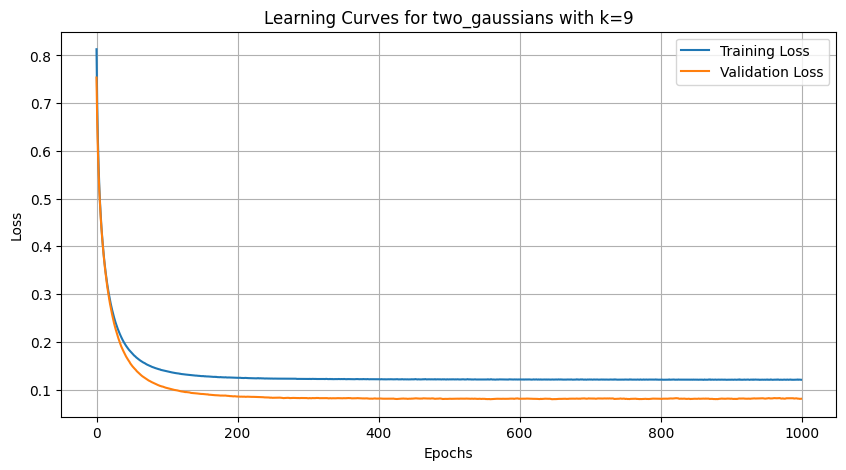

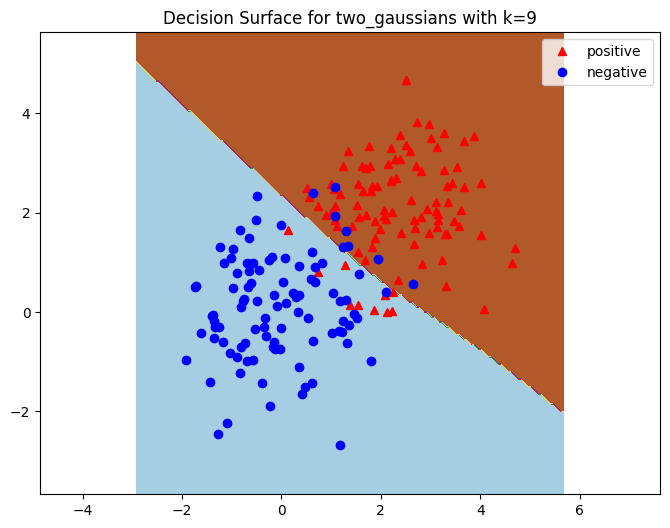


Processing dataset: spiral

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.9662, Validation Loss: 0.9108
Epoch [100/1000], Training Loss: 0.5436, Validation Loss: 0.6223
Epoch [200/1000], Training Loss: 0.4931, Validation Loss: 0.5460
Epoch [300/1000], Training Loss: 0.4823, Validation Loss: 0.5495
Epoch [400/1000], Training Loss: 0.5012, Validation Loss: 0.6424
Epoch [500/1000], Training Loss: 0.4999, Validation Loss: 0.5930
Epoch [600/1000], Training Loss: 0.4873, Validation Loss: 0.5502
Epoch [700/1000], Training Loss: 0.4954, Validation Loss: 0.5499
Epoch [800/1000], Training Loss: 0.4979, Validation Loss: 0.5298
Epoch [900/1000], Training Loss: 0.5032, Validation Loss: 0.5355
Epoch [1000/1000], Training Loss: 0.4924, Validation Loss: 0.5502
Validation Accuracy for k=2: 0.7350

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 1.0509, Validation Loss: 0.9745
Epoch [100/1000], Training Loss: 0.5378, Validation Loss: 0.6371
Epoch [200/1000], Tr

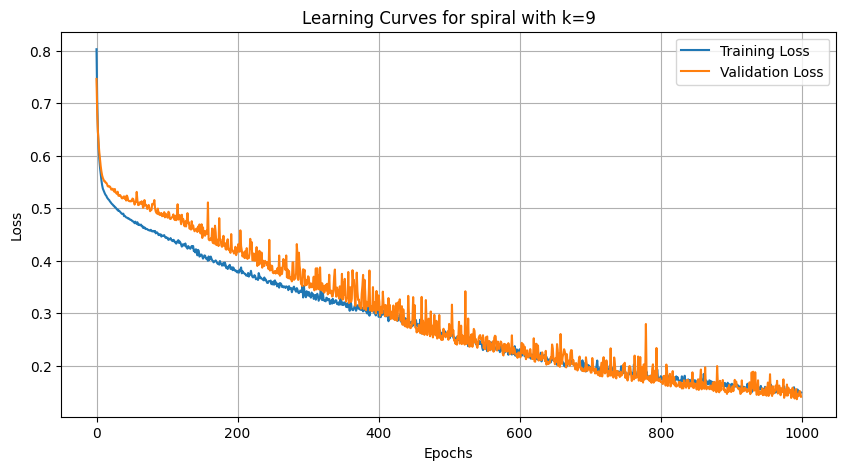

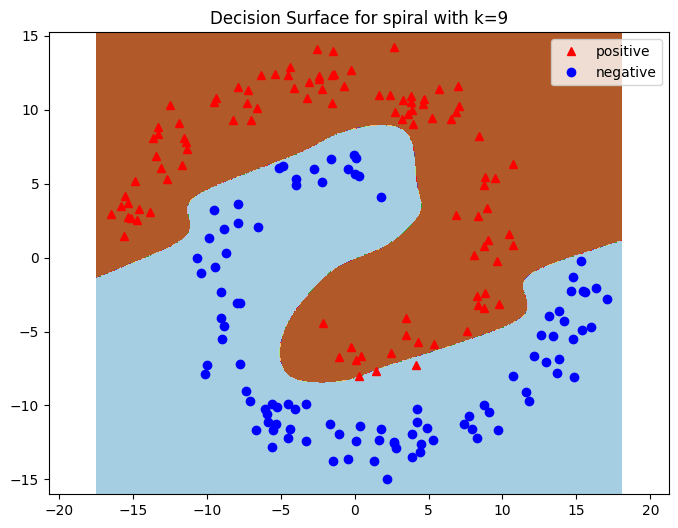

In [32]:
# Main execution loop for question 1
datasets = ['xor', 'center_surround', 'two_gaussians', 'spiral']

for dataset_name in datasets:
    print(f"\nProcessing dataset: {dataset_name}")
    
    # Read the datasets
    X_train, y_train, labels_train = read_data(dataset_name, 'train')
    X_test, y_test, labels_test = read_data(dataset_name, 'test')
    X_valid, y_valid, labels_valid = read_data(dataset_name, 'valid')
    
    # Remove bias term from all datasets if included
    if X_train.shape[1] == 3:  # If bias term is included
        X_train = X_train[:, 1:]  # Remove bias term
        X_valid = X_valid[:, 1:]  # Remove bias term
        X_test = X_test[:, 1:]    # Remove bias term

    
    # Convert to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long().squeeze()
    X_val_tensor = torch.from_numpy(X_valid).float()
    y_val_tensor = torch.from_numpy(y_valid).long().squeeze()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long().squeeze()
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the range of hidden layer sizes to experiment with
    k_values = [2, 3, 5, 7, 9]
    
    # Initialize variables to keep track of the best model
    best_val_loss = float('inf')
    best_k = None
    best_model = None
    
    # Dictionaries to store training and validation losses for each k
    train_losses_dict = {}
    val_losses_dict = {}
    val_accuracies_dict = {}
    
    # Iterate over different hidden layer sizes
    for k in k_values:
        print(f"\nTraining with hidden layer size k={k}")
        
        # Initialize the model
        model = FFNN(input_size=X_train_tensor.shape[1], hidden_size=k, output_size=2)
        
        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        # Number of epochs
        num_epochs = 1000
        
        # Train the model
        train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
        
        # Store the losses
        train_losses_dict[k] = train_losses
        val_losses_dict[k] = val_losses
        
        # After training, evaluate validation accuracy
        # (This has already been done inside train_model and printed)
        # To store it, you need to capture it during training
        # For simplicity, we'll compute it again here
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
        val_accuracy = correct / total
        val_accuracies_dict[k] = val_accuracy
        print(f"Validation Accuracy for k={k}: {val_accuracy:.4f}")
        
        # Check if this model is the best so far
        val_loss = val_losses[-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_k = k
            best_model = model

    # After evaluating all k's, print a summary table
    print(f"\nSummary of Results for dataset: {dataset_name}")
    print(f"{'k':<5}{'Val Loss':<15}{'Val Accuracy':<15}")
    for k in k_values:
        print(f"{k:<5}{val_losses_dict[k][-1]:<15.4f}{val_accuracies_dict[k]:<15.4f}")
    
    print(f"\nBest k for {dataset_name}: {best_k} with Validation Loss: {best_val_loss:.4f} and Validation Accuracy: {val_accuracies_dict[best_k]:.4f}")
    
    # Evaluate the best model on the test set
    best_model.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()
    test_accuracy = correct / total
    print(f"Test Accuracy for {dataset_name} with k={best_k}: {test_accuracy:.2f}")
    
    # (a) List hyperparameters
    print(f"\nHyperparameters for {dataset_name}:")
    print(f"Learning Rate: 0.01")
    print(f"Number of Epochs: {num_epochs}")
    print(f"Batch Size: {batch_size}")
    print(f"Hidden Layer Size (k): {best_k}")
    print(f"Activation Function: Tanh")
    print(f"Optimizer: SGD")
    
    # (b) Plot learning curves
    plt.figure(figsize=(10,5))
    plt.plot(train_losses_dict[best_k], label='Training Loss')
    plt.plot(val_losses_dict[best_k], label='Validation Loss')
    plt.title(f"Learning Curves for {dataset_name} with k={best_k}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # (d) Plot decision boundary using provided plotting functions
    # Map labels for plotting (from class indices to -1/+1)
    y_test_np = y_test_tensor.numpy()
    X_test_np = X_test_tensor.numpy()
    labels_test_mapped = np.where(y_test_np == 0, -1, 1)

    
    def model_for_plotting(input_data):
        with torch.no_grad():
            inputs = torch.from_numpy(input_data).float()
            outputs = best_model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_labels = np.where(predicted.numpy() == 0, -1, 1)
            return predicted_labels
    
    # Compute axis limits based on test data
    axis_limits = [X_test_np[:, 0].min() - 1, X_test_np[:, 0].max() + 1,
                   X_test_np[:, 1].min() - 1, X_test_np[:, 1].max() + 1]
    
    # Plot the decision surface
    plt.figure(figsize=(8, 6))
    plot_decision_surface(model=model_for_plotting, axis_limits=axis_limits)
    
    # Overlay the test data
    plot_data(X_test_np, labels_test_mapped)
    
    plt.title(f"Decision Surface for {dataset_name} with k={best_k}")
    plt.show()


Processing dataset: xor

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.2878, Validation Loss: 0.3048
Epoch [100/1000], Training Loss: 0.1951, Validation Loss: 0.2199
Epoch [200/1000], Training Loss: 0.1694, Validation Loss: 0.1880
Epoch [300/1000], Training Loss: 0.1661, Validation Loss: 0.1854
Epoch [400/1000], Training Loss: 0.1656, Validation Loss: 0.1837
Epoch [500/1000], Training Loss: 0.1655, Validation Loss: 0.1846
Epoch [600/1000], Training Loss: 0.1655, Validation Loss: 0.1843
Epoch [700/1000], Training Loss: 0.1654, Validation Loss: 0.1850
Epoch [800/1000], Training Loss: 0.1660, Validation Loss: 0.1863
Epoch [900/1000], Training Loss: 0.1654, Validation Loss: 0.1874
Epoch [1000/1000], Training Loss: 0.1652, Validation Loss: 0.1849
Validation Accuracy for k=2: 0.7050

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.6234, Validation Loss: 0.6181
Epoch [100/1000], Training Loss: 0.1787, Validation Loss: 0.2026
Epoch [200/1000], Train

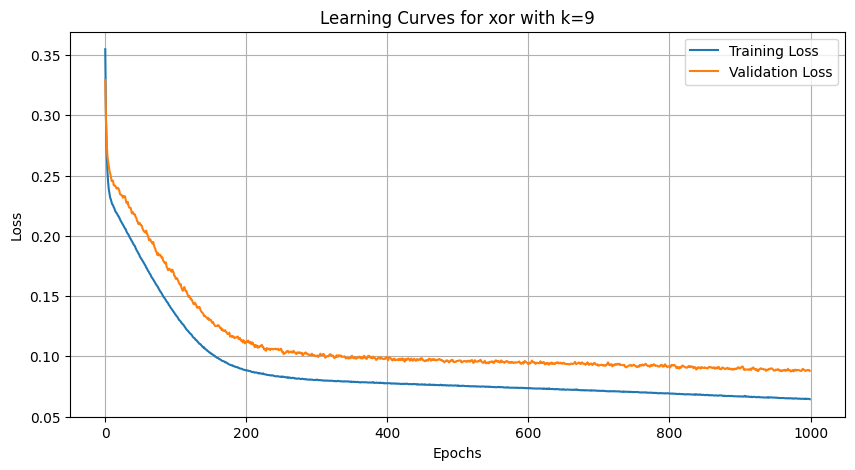

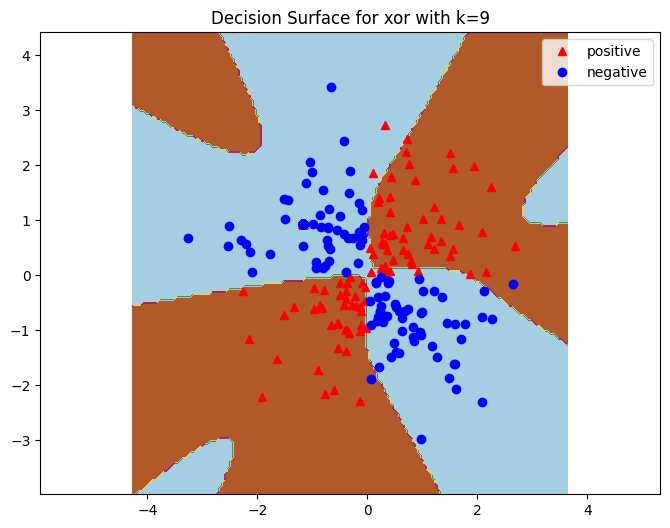


Processing dataset: center_surround

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.3316, Validation Loss: 0.2887
Epoch [100/1000], Training Loss: 0.2346, Validation Loss: 0.2293
Epoch [200/1000], Training Loss: 0.1555, Validation Loss: 0.1208
Epoch [300/1000], Training Loss: 0.1428, Validation Loss: 0.1241
Epoch [400/1000], Training Loss: 0.1384, Validation Loss: 0.1078
Epoch [500/1000], Training Loss: 0.1384, Validation Loss: 0.1056
Epoch [600/1000], Training Loss: 0.1379, Validation Loss: 0.1059
Epoch [700/1000], Training Loss: 0.1378, Validation Loss: 0.1051
Epoch [800/1000], Training Loss: 0.1377, Validation Loss: 0.1053
Epoch [900/1000], Training Loss: 0.1375, Validation Loss: 0.1053
Epoch [1000/1000], Training Loss: 0.1375, Validation Loss: 0.1057
Validation Accuracy for k=2: 0.8700

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.2680, Validation Loss: 0.2788
Epoch [100/1000], Training Loss: 0.1374, Validation Loss: 0.1059
Epoch [200/

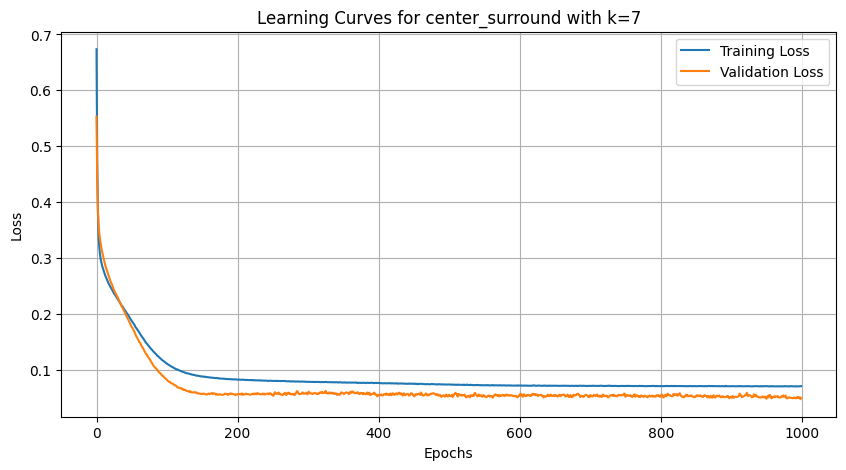

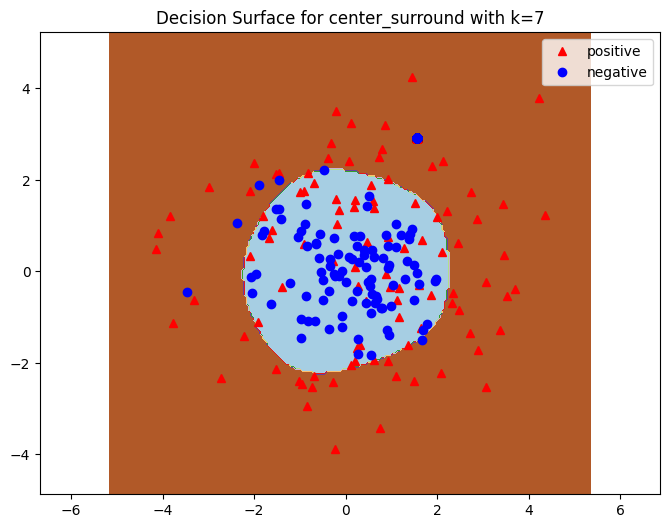


Processing dataset: two_gaussians

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.1024, Validation Loss: 0.0726
Epoch [100/1000], Training Loss: 0.0531, Validation Loss: 0.0437
Epoch [200/1000], Training Loss: 0.0476, Validation Loss: 0.0375
Epoch [300/1000], Training Loss: 0.0434, Validation Loss: 0.0330
Epoch [400/1000], Training Loss: 0.0406, Validation Loss: 0.0290
Epoch [500/1000], Training Loss: 0.0391, Validation Loss: 0.0273
Epoch [600/1000], Training Loss: 0.0381, Validation Loss: 0.0264
Epoch [700/1000], Training Loss: 0.0377, Validation Loss: 0.0261
Epoch [800/1000], Training Loss: 0.0375, Validation Loss: 0.0258
Epoch [900/1000], Training Loss: 0.0372, Validation Loss: 0.0253
Epoch [1000/1000], Training Loss: 0.0371, Validation Loss: 0.0251
Validation Accuracy for k=2: 0.9750

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.2870, Validation Loss: 0.2101
Epoch [100/1000], Training Loss: 0.0597, Validation Loss: 0.0473
Epoch [200/10

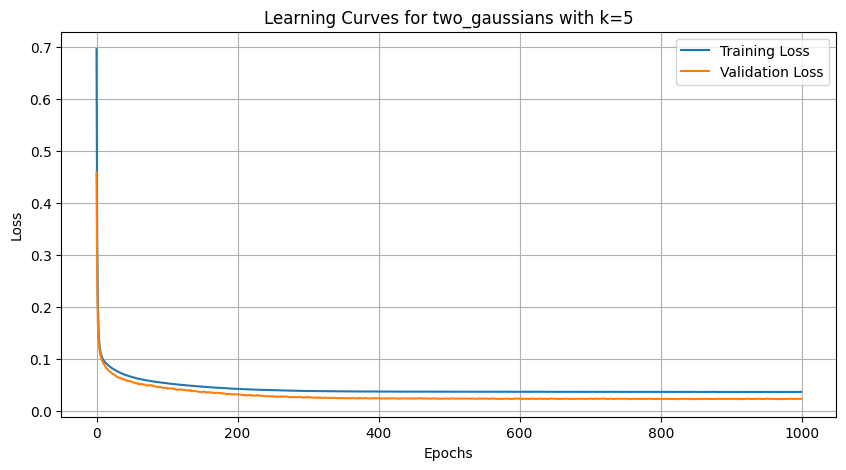

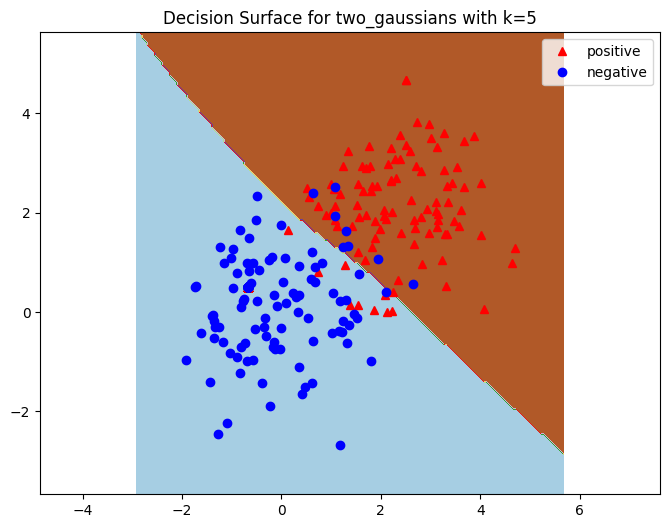


Processing dataset: spiral

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.6963, Validation Loss: 0.5438
Epoch [100/1000], Training Loss: 0.1353, Validation Loss: 0.1434
Epoch [200/1000], Training Loss: 0.1200, Validation Loss: 0.1581
Epoch [300/1000], Training Loss: 0.1175, Validation Loss: 0.1421
Epoch [400/1000], Training Loss: 0.1091, Validation Loss: 0.1347
Epoch [500/1000], Training Loss: 0.1212, Validation Loss: 0.1509
Epoch [600/1000], Training Loss: 0.1276, Validation Loss: 0.1192
Epoch [700/1000], Training Loss: 0.1113, Validation Loss: 0.1333
Epoch [800/1000], Training Loss: 0.1142, Validation Loss: 0.1298


KeyboardInterrupt: 

In [31]:
# Main execution loop for question 2
datasets = ['xor', 'center_surround', 'two_gaussians', 'spiral']

for dataset_name in datasets:
    print(f"\nProcessing dataset: {dataset_name}")
    
    # Read the datasets
    X_train, y_train, labels_train = read_data(dataset_name, 'train')
    X_test, y_test, labels_test = read_data(dataset_name, 'test')
    X_valid, y_valid, labels_valid = read_data(dataset_name, 'valid')
    
    # Remove bias term from all datasets if included
    if X_train.shape[1] == 3:  # If bias term is included
        X_train = X_train[:, 1:]  # Remove bias term
        X_valid = X_valid[:, 1:]  # Remove bias term
        X_test = X_test[:, 1:]    # Remove bias term

    
    # Convert to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    X_val_tensor = torch.from_numpy(X_valid).float()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    y_val_tensor = torch.from_numpy(y_valid).float()
    y_test_tensor = torch.from_numpy(y_test).float()
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the range of hidden layer sizes to experiment with
    k_values = [2, 3, 5, 7, 9]
    
    # Initialize variables to keep track of the best model
    best_val_loss = float('inf')
    best_k = None
    best_model = None
    
    # Dictionaries to store training and validation losses for each k
    train_losses_dict = {}
    val_losses_dict = {}
    val_accuracies_dict = {}
    
    # Iterate over different hidden layer sizes
    for k in k_values:
        print(f"\nTraining with hidden layer size k={k}")
        
        # Initialize the model
        model = FFNN(input_size=X_train_tensor.shape[1], hidden_size=k, output_size=1)

        
        # Define the loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        # Number of epochs
        num_epochs = 1000
        
        # Train the model
        train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
        
        # Store the losses
        train_losses_dict[k] = train_losses
        val_losses_dict[k] = val_losses
        
        # After training, evaluate validation accuracy
        # (This has already been done inside train_model and printed)
        # To store it, you need to capture it during training
        # For simplicity, we'll compute it again here
        model.eval()
        correct = 0
        # total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                predicted = torch.round(outputs)
                # total += labels.size(0)
                correct += (predicted == labels).sum()
        val_accuracy = correct / len(val_dataset)
        val_accuracies_dict[k] = val_accuracy
        print(f"Validation Accuracy for k={k}: {val_accuracy:.4f}")
        
        # Check if this model is the best so far
        val_loss = val_losses[-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_k = k
            best_model = model

    # After evaluating all k's, print a summary table
    print(f"\nSummary of Results for dataset: {dataset_name}")
    print(f"{'k':<5}{'Val Loss':<15}{'Val Accuracy':<15}")
    for k in k_values:
        print(f"{k:<5}{val_losses_dict[k][-1]:<15.4f}{val_accuracies_dict[k]:<15.4f}")
    
    print(f"\nBest k for {dataset_name}: {best_k} with Validation Loss: {best_val_loss:.4f} and Validation Accuracy: {val_accuracies_dict[best_k]:.4f}")
    
    # Evaluate the best model on the test set
    best_model.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f"Test Accuracy for {dataset_name} with k={best_k}: {test_accuracy:.2f}")
    
    # (a) List hyperparameters
    print(f"\nHyperparameters for {dataset_name}:")
    print(f"Learning Rate: 0.01")
    print(f"Number of Epochs: {num_epochs}")
    print(f"Batch Size: {batch_size}")
    print(f"Hidden Layer Size (k): {best_k}")
    print(f"Activation Function: Tanh")
    print(f"Optimizer: SGD")
    
    # (b) Plot learning curves
    plt.figure(figsize=(10,5))
    plt.plot(train_losses_dict[best_k], label='Training Loss')
    plt.plot(val_losses_dict[best_k], label='Validation Loss')
    plt.title(f"Learning Curves for {dataset_name} with k={best_k}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # (d) Plot decision boundary using provided plotting functions
    # Map labels for plotting (from class indices to -1/+1)
    y_test_np = y_test_tensor.numpy()
    X_test_np = X_test_tensor.numpy()
    labels_test_mapped = np.where(y_test_np == 0, -1, 1)

    
    def model_for_plotting(input_data):
        with torch.no_grad():
            inputs = torch.from_numpy(input_data).float()
            outputs = best_model(inputs)
            predicted = torch.round(outputs)
            predicted_labels = np.where(predicted.numpy() == 0, -1, 1)
            return predicted_labels
    
    # Compute axis limits based on test data
    axis_limits = [X_test_np[:, 0].min() - 1, X_test_np[:, 0].max() + 1,
                   X_test_np[:, 1].min() - 1, X_test_np[:, 1].max() + 1]
    
    # Plot the decision surface
    plt.figure(figsize=(8, 6))
    plot_decision_surface(model=model_for_plotting, axis_limits=axis_limits)
    
    # Overlay the test data
    plot_data(X_test_np, labels_test_mapped)
    
    plt.title(f"Decision Surface for {dataset_name} with k={best_k}")
    plt.show()

In [6]:
# Activation Functions and Their Derivatives
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)

def tanh(z):
    return np.tanh(z)

def tanh_derivative(a):
    return 1 - np.square(a)

# Initialize Parameters
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)  # For reproducibility

    W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2. / input_size)
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2. / hidden_size)
    b2 = np.zeros((output_size, 1))
    return W1, b1, W2, b2

# Forward Pass
def forward_pass(X, W1, b1, W2, b2, activation='tanh'):
    Z1 = np.dot(W1, X) + b1
    if activation == 'tanh':
        A1 = tanh(Z1)
    elif activation == 'sigmoid':
        A1 = sigmoid(Z1)
    else:
        raise ValueError("Unsupported activation function")
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    cache = (Z1, A1, Z2, A2)
    return A2, cache

# Compute Loss
def compute_loss(Y, A2):
    m = Y.shape[1]
    epsilon = 1e-15  # To avoid log(0)
    loss = - (1/m) * np.sum(Y * np.log(A2 + epsilon) + (1 - Y) * np.log(1 - A2 + epsilon))
    return loss

# Backward Pass
def backward_pass(X, Y, cache, W2, activation='tanh'):
    Z1, A1, Z2, A2 = cache
    m = X.shape[1]

    # Output layer gradients
    dZ2 = A2 - Y  # (output_size, m)
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # Hidden layer gradients
    dA1 = np.dot(W2.T, dZ2)
    if activation == 'tanh':
        dZ1 = dA1 * tanh_derivative(A1)
    elif activation == 'sigmoid':
        dZ1 = dA1 * sigmoid_derivative(A1)
    else:
        raise ValueError("Unsupported activation function")
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dW1": dW1, "db1": db1,
                 "dW2": dW2, "db2": db2}
    return gradients

# Update Parameters
def update_parameters(W1, b1, W2, b2, gradients, learning_rate):
    W1 -= learning_rate * gradients["dW1"]
    b1 -= learning_rate * gradients["db1"]
    W2 -= learning_rate * gradients["dW2"]
    b2 -= learning_rate * gradients["db2"]
    return W1, b1, W2, b2

# Prediction Function
def predict(X, parameters, activation='tanh'):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    A2, _ = forward_pass(X, W1, b1, W2, b2, activation=activation)
    predictions = (A2 > 0.5).astype(int)
    return predictions

# Compute Accuracy
def compute_accuracy(predictions, Y):
    return np.mean(predictions == Y) * 100

# Training Function
def train_nn(X_train, Y_train, X_val, Y_val, hidden_size=3, learning_rate=0.1, num_epochs=1000, activation='tanh'):
    input_size = X_train.shape[0]
    output_size = Y_train.shape[0]

    # Initialize parameters
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)

    # Training loop
    for epoch in range(1, num_epochs + 1):
        # Forward pass
        A2, cache = forward_pass(X_train, W1, b1, W2, b2, activation=activation)

        # Compute loss
        loss = compute_loss(Y_train, A2)

        # Backward pass
        gradients = backward_pass(X_train, Y_train, cache, W2, activation=activation)

        # Update parameters
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, gradients, learning_rate)

        # Optionally, compute validation loss and print progress
        if epoch % 100 == 0 or epoch == 1:
            A2_val, _ = forward_pass(X_val, W1, b1, W2, b2, activation=activation)
            val_loss = compute_loss(Y_val, A2_val)
            print(f"Epoch {epoch}: Training Loss = {loss:.6f}, Validation Loss = {val_loss:.6f}")

    parameters = {"W1": W1, "b1": b1,
                  "W2": W2, "b2": b2}
    return parameters

In [52]:
for dataset_name in datasets:
    print(f"\nProcessing dataset: {dataset_name}")

    # Load your data using the existing read_data function
    name = dataset_name
    mode_train = 'train'
    mode_val = 'valid'
    mode_test = 'test'

    X_train, Y_train, _ = read_data(name, mode_train)  # X_train: (m, n)
    X_val, Y_val, _ = read_data(name, mode_val)
    X_test, Y_test, _ = read_data(name, mode_test)

    # Preprocess data
    # No need to remove columns if data is already clean
    # Transpose to get shape (input_size, m)
    X_train = X_train[:, 1:].T  # Shape: (input_size, m)
    X_val = X_val[:, 1:].T
    X_test = X_test[:, 1:].T


    Y_train = Y_train.T  # Shape: (1, m)
    Y_val = Y_val.T
    Y_test = Y_test.T

    # Set hyperparameters
    hidden_size = 3  # Adjust as needed
    learning_rate = 0.1
    num_epochs = 1000
    activation = 'tanh'

    # Adjust hyperparameters for specific datasets if needed
    if dataset_name == 'spiral':
        hidden_size = 10
        num_epochs = 5000
        activation = 'tanh'

    # Train the neural network
    parameters = train_nn(X_train, Y_train, X_val, Y_val,
                          hidden_size=hidden_size,
                          learning_rate=learning_rate,
                          num_epochs=num_epochs,
                          activation=activation)

    # Predict on test set
    predictions = predict(X_test, parameters, activation=activation)
    accuracy = compute_accuracy(predictions, Y_test)
    print(f"Test Accuracy on {dataset_name}: {accuracy:.2f}%")
    
  


Processing dataset: xor
Epoch 1: Training Loss = 0.833434, Validation Loss = 0.796297
Epoch 100: Training Loss = 0.659587, Validation Loss = 0.705806
Epoch 200: Training Loss = 0.620857, Validation Loss = 0.673749
Epoch 300: Training Loss = 0.577383, Validation Loss = 0.627617
Epoch 400: Training Loss = 0.546130, Validation Loss = 0.593739
Epoch 500: Training Loss = 0.526853, Validation Loss = 0.573571
Epoch 600: Training Loss = 0.513582, Validation Loss = 0.560360
Epoch 700: Training Loss = 0.498400, Validation Loss = 0.546200
Epoch 800: Training Loss = 0.470618, Validation Loss = 0.521191
Epoch 900: Training Loss = 0.430125, Validation Loss = 0.484977
Epoch 1000: Training Loss = 0.390668, Validation Loss = 0.449540
Test Accuracy on xor: 80.00%

Processing dataset: center_surround
Epoch 1: Training Loss = 0.837030, Validation Loss = 0.751621
Epoch 100: Training Loss = 0.600155, Validation Loss = 0.586169
Epoch 200: Training Loss = 0.525302, Validation Loss = 0.496638
Epoch 300: Train

In [63]:
np.concatenate((X1_train, X2_train), axis=1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 199 and the array at index 1 has size 200

In [31]:
X_train


array([[-9.3100e-01,  6.6520e-01, -5.9220e-01,  1.7183e+00, -5.2690e-01,
        -1.5392e+00, -2.8840e-01, -1.6560e-01, -1.9653e+00,  8.1950e-01,
        -1.2300e+00, -3.9430e-01, -2.2500e-01,  1.4968e+00, -2.6530e-01,
         1.0149e+00, -1.0318e+00,  1.0216e+00, -1.1340e-01,  6.5520e-01,
        -2.1430e-01,  1.3071e+00,  8.6150e-01, -2.5870e-01,  1.1590e+00,
         4.2250e-01, -1.4408e+00, -1.0099e+00,  3.8440e-01,  5.2890e-01,
         7.8740e-01,  4.8200e-01, -3.2830e-01,  1.6250e-01,  9.1570e-01,
        -1.0290e-01,  1.7550e-01,  4.8820e-01, -7.0780e-01,  4.7990e-01,
         8.8000e-02,  5.0300e-01,  2.0870e+00, -8.1360e-01, -9.2900e-02,
         3.6040e-01,  3.2720e-01,  6.3710e-01, -1.6430e-01,  1.1668e+00,
         1.4372e+00, -7.9260e-01, -3.0981e+00, -4.8880e-01, -8.8030e-01,
        -5.0130e-01, -5.0180e-01, -5.1400e-02, -3.7750e-01,  6.4950e-01,
         1.0579e+00,  1.0289e+00,  6.0900e-01,  2.4890e-01, -5.8070e-01,
        -4.1800e-01, -9.9520e-01, -2.1940e+00, -6.9

In [20]:
Y_train.T

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],